In [1]:
# Cella 1: Installazione delle dipendenze
!pip install spacy transformers torch pandas matplotlib seaborn scikit-learn numpy
!python -m spacy download it_core_news_lg
# Installa le dipendenze necessarie
!pip install -q transformers bitsandbytes accelerate psutil
!pip install -q sentencepiece  # Necessario per molti tokenizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
# Cella 2: Definizione delle classi principali
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import spacy
import re
import gc
import psutil
import warnings

from sklearn.metrics import classification_report
from typing import List, Dict, Tuple, Any, Optional
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from pathlib import Path
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# Impostazione per permettere l'espansione dinamica dei segmenti CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def check_memory_usage():
    """
    Verifica e stampa l'utilizzo corrente della memoria
    """
    # Memoria RAM
    process = psutil.Process(os.getpid())
    ram_usage = process.memory_info().rss / (1024 * 1024)  # In MB

    # Memoria GPU se disponibile
    gpu_usage = None
    if torch.cuda.is_available():
        gpu_usage = torch.cuda.memory_allocated() / (1024 * 1024)  # In MB

    print(f"Utilizzo RAM: {ram_usage:.2f} MB")
    if gpu_usage is not None:
        print(f"Utilizzo GPU: {gpu_usage:.2f} MB")

    return ram_usage, gpu_usage

def clean_memory():
    """
    Pulisce la memoria liberando le cache di PyTorch e richiamando il garbage collector
    """
    # Libera la cache PyTorch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Esegui il garbage collector di Python
    gc.collect()

    print("Memoria liberata")

def verify_llamantino_model(model):
    """
    Verifica se il modello LLaMAntino è reale o simulato

    Args:
        model: Istanza del modello LLaMAntino

    Returns:
        bool: True se è il modello reale, False se è simulato
    """
    is_real = False
    reasons = []

    # Verifica 1: Attributo esplicito (se presente)
    if hasattr(model, 'is_real_model'):
        is_real = model.is_real_model
        reasons.append(f"Attributo is_real_model: {is_real}")

    # Verifica 2: Presenza di attributi del modello reale
    if hasattr(model, 'model') and hasattr(model, 'tokenizer'):
        is_real = True
        reasons.append("Presenza di tokenizer e model")

        # Verifica sottotipo
        if 'AutoModelForCausalLM' in str(type(model.model)):
            reasons.append("Model è di tipo AutoModelForCausalLM")
        else:
            reasons.append(f"Model è di tipo inatteso: {type(model.model)}")
    else:
        reasons.append("Mancanza di tokenizer o model")

    # Stampa risultato
    status = "REALE ✅" if is_real else "SIMULATO ⚠️"
    print(f"\nVerifica modello LLaMAntino: {status}")
    print("Motivazioni:")
    for reason in reasons:
        print(f"- {reason}")

    return is_real

# Classe per caricare e gestire dati IOB
class IOBDataLoader:
    """
    Classe per caricare e gestire dati in formato IOB per NER
    """
    def __init__(self, iob_file_path: str = None, classes_file_path: str = None):
        """
        Inizializza il data loader

        Args:
            iob_file_path: Percorso al file in formato IOB
            classes_file_path: Percorso al file con le classi di entità
        """
        self.iob_file_path = iob_file_path
        self.classes_file_path = classes_file_path
        self.documents = []
        self.entity_classes = []

        if classes_file_path:
            self.load_entity_classes()

        if iob_file_path:
            self.load_iob_data()

    def load_entity_classes(self):
        """Carica le classi di entità da un file"""
        with open(self.classes_file_path, 'r', encoding='utf-8') as f:
            self.entity_classes = [line.strip() for line in f if line.strip()]

    def load_iob_data(self):
        """Carica i dati in formato IOB"""
        self.documents = []
        current_doc = {"tokens": [], "tags": []}

        with open(self.iob_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    # Fine documento
                    if current_doc["tokens"]:
                        self.documents.append(current_doc)
                        current_doc = {"tokens": [], "tags": []}
                    continue

                # Dividiamo per tab o spazi multipli
                parts = re.split(r'\t+|\s+', line.strip(), maxsplit=1)
                if len(parts) == 2:
                    token, tag = parts
                    current_doc["tokens"].append(token)
                    current_doc["tags"].append(tag)

            # Aggiungiamo l'ultimo documento se non è vuoto
            if current_doc["tokens"]:
                self.documents.append(current_doc)

    def get_entity_statistics(self):
        """Calcola statistiche sulle entità nel dataset"""
        entity_counts = {}
        total_tokens = 0
        total_entities = 0

        for doc in self.documents:
            total_tokens += len(doc["tokens"])

            for tag in doc["tags"]:
                if tag.startswith("B-"):
                    entity_type = tag[2:]  # Rimuove "B-"
                    entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
                    total_entities += 1

        return {
            "entity_counts": entity_counts,
            "total_tokens": total_tokens,
            "total_entities": total_entities,
            "entity_density": (total_entities / total_tokens) * 100 if total_tokens > 0 else 0
        }

    def get_documents(self):
        """Restituisce tutti i documenti caricati"""
        return self.documents

    def get_entity_classes(self):
        """Restituisce le classi di entità"""
        return self.entity_classes

    def convert_to_spacy_format(self):
        """Converte i dati nel formato richiesto da spaCy"""
        spacy_data = []

        for doc in self.documents:
            entities = []
            current_entity = None

            for i, (token, tag) in enumerate(zip(doc["tokens"], doc["tags"])):
                # Calcoliamo gli indici di carattere (approssimati)
                start_char = len(" ".join(doc["tokens"][:i]))
                end_char = start_char + len(token)

                if tag.startswith("B-"):
                    # Inizia una nuova entità
                    entity_type = tag[2:]
                    current_entity = (start_char, end_char, entity_type)

                elif tag.startswith("I-"):
                    # Continua l'entità corrente
                    if current_entity:
                        # Aggiorniamo solo l'endpoint
                        current_entity = (current_entity[0], end_char, current_entity[2])

                elif current_entity:
                    # Aggiunge l'entità completata e resetta
                    entities.append(current_entity)
                    current_entity = None

            # Aggiungiamo l'ultima entità se è rimasta aperta
            if current_entity:
                entities.append(current_entity)

            # Creiamo l'oggetto documento
            spacy_doc = {
                "text": " ".join(doc["tokens"]),
                "entities": entities
            }
            spacy_data.append(spacy_doc)

        return spacy_data

# Classe per valutare le prestazioni dei modelli NER
class NEREvaluator:
    """
    Classe per valutare le prestazioni dei modelli NER
    """
    def __init__(self):
        self.metrics = {}

    def evaluate(self, true_tags: List[List[str]], pred_tags: List[List[str]], entity_classes: List[str]):
        """
        Valuta le prestazioni del modello

        Args:
            true_tags: Tag veri (ground truth)
            pred_tags: Tag predetti dal modello
            entity_classes: Lista delle classi di entità

        Returns:
            Dict con metriche di valutazione
        """
        # Appiattisci le liste
        true_flat = []
        pred_flat = []

        for doc_true, doc_pred in zip(true_tags, pred_tags):
            true_flat.extend(doc_true)
            pred_flat.extend(doc_pred)

        # Calcoliamo le metriche usando sklearn
        report = classification_report(true_flat, pred_flat, output_dict=True)

        # Filtriamo solo le classi di entità rilevanti (escludendo 'O')
        entity_metrics = {
            entity: report.get(entity, {})
            for entity in [f"B-{ec[2:]}" if ec.startswith("B-") else ec for ec in entity_classes
                          if ec != "O"]
        }

        # Aggiungiamo le metriche macro e micro
        self.metrics = {
            "entity_metrics": entity_metrics,
            "macro_avg": report.get("macro avg", {}),
            "weighted_avg": report.get("weighted avg", {})
        }

        return self.metrics

    def evaluate_token_level(self, true_tags: List[List[str]], pred_tags: List[List[str]]):
        """
        Valuta a livello di token (precision, recall, F1)
        """
        true_flat = []
        pred_flat = []

        for doc_true, doc_pred in zip(true_tags, pred_tags):
            true_flat.extend(doc_true)
            pred_flat.extend(doc_pred)

        total = len(true_flat)
        correct = sum(1 for t, p in zip(true_flat, pred_flat) if t == p)

        return {
            "token_accuracy": correct / total if total > 0 else 0
        }

    def evaluate_entity_level(self, true_docs, pred_docs):
        """
        Valuta a livello di entità completa (exact match)
        """
        true_entities = []
        pred_entities = []

        # Estrai le entità dai veri tag
        for doc in true_docs:
            entities = self._extract_entities_from_tags(doc["tokens"], doc["tags"])
            true_entities.extend(entities)

        # Estrai le entità dai tag predetti
        for tokens, tags in zip([doc["tokens"] for doc in true_docs], pred_docs):
            entities = self._extract_entities_from_tags(tokens, tags)
            pred_entities.extend(entities)

        # Calcola precision, recall e F1
        true_set = set((e["text"], e["type"]) for e in true_entities)
        pred_set = set((e["text"], e["type"]) for e in pred_entities)

        correct = len(true_set.intersection(pred_set))

        precision = correct / len(pred_set) if pred_set else 0
        recall = correct / len(true_set) if true_set else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        return {
            "entity_precision": precision,
            "entity_recall": recall,
            "entity_f1": f1
        }

    def _extract_entities_from_tags(self, tokens, tags):
        """Estrae entità da token e tag"""
        entities = []
        current_entity = {"text": "", "type": "", "start": -1, "end": -1}

        for i, (token, tag) in enumerate(zip(tokens, tags)):
            if tag.startswith("B-"):
                # Se c'era un'entità precedente, la salviamo
                if current_entity["start"] != -1:
                    entities.append(current_entity.copy())

                # Iniziamo una nuova entità
                entity_type = tag[2:]
                current_entity = {
                    "text": token,
                    "type": entity_type,
                    "start": i,
                    "end": i
                }

            elif tag.startswith("I-"):
                # Continuiamo l'entità corrente
                if current_entity["start"] != -1:
                    current_entity["text"] += " " + token
                    current_entity["end"] = i

            elif current_entity["start"] != -1:
                # Fine entità
                entities.append(current_entity.copy())
                current_entity = {"text": "", "type": "", "start": -1, "end": -1}

        # Aggiungiamo l'ultima entità se è rimasta aperta
        if current_entity["start"] != -1:
            entities.append(current_entity.copy())

        return entities

In [2]:
# Cella 3: Implementazione dei modelli

# Modello spaCy
class SpacyNERModel:
    """
    Wrapper per modelli spaCy NER
    """
    def __init__(self, model_name="it_core_news_lg"):
        """
        Inizializza il modello spaCy

        Args:
            model_name: Nome del modello spaCy da utilizzare
        """
        try:
            self.nlp = spacy.load(model_name)
        except OSError:
            # Se il modello non è installato, lo scarichiamo
            print(f"Scaricamento del modello spaCy {model_name}...")
            spacy.cli.download(model_name)
            self.nlp = spacy.load(model_name)

        self.model_name = model_name

    def predict_iob(self, documents):
        """
        Esegue previsioni su documenti in formato IOB

        Args:
            documents: Lista di documenti con "tokens" e "tags"

        Returns:
            Lista di liste di tag NER
        """
        predictions = []

        for doc in documents:
            # Ricostruiamo il testo
            text = " ".join(doc["tokens"])

            # Facciamo la previsione
            spacy_doc = self.nlp(text)

            # Convertiamo in tag IOB
            tags = ["O"] * len(doc["tokens"])
            token_ends = []

            # Calcoliamo gli indici di fine per ogni token
            pos = 0
            for token in doc["tokens"]:
                pos += len(token) + 1  # +1 per lo spazio
                token_ends.append(pos - 1)

            # Assegniamo i tag
            for ent in spacy_doc.ents:
                for i, (token, end_pos) in enumerate(zip(doc["tokens"], token_ends)):
                    token_start = end_pos - len(token)

                    # Controlliamo se il token è all'interno dell'entità
                    if ent.start_char <= token_start < ent.end_char:
                        # Se è il primo token dell'entità
                        if i == 0 or tags[i-1] == "O" or not tags[i-1].endswith(f"-{ent.label_}"):
                            tags[i] = f"B-{ent.label_}"
                        else:
                            tags[i] = f"I-{ent.label_}"

            predictions.append(tags)

        return predictions

# Modello GLiNER
class GLiNERModel:
    """
    Wrapper per GLiNER - Generative Language model for Italian NER
    """
    def __init__(self, model_path="DeepMount00/GLiNER_ITA_LARGE"):
        """
        Inizializza il modello GLiNER

        Args:
            model_path: Percorso al modello pre-addestrato
        """
        self.model_path = model_path
        # Nota: In un'implementazione reale, qui si caricherà il modello
        # ma per semplicità, simulo il comportamento
        print(f"Inizializzazione modello GLiNER da {model_path}")

    def predict_iob(self, documents, entity_types=None):
        """
        Esegue previsioni su documenti in formato IOB (versione simulata)

        Args:
            documents: Lista di documenti con "tokens" e "tags"
            entity_types: Tipi di entità da riconoscere (opzionale)

        Returns:
            Lista di liste di tag NER
        """
        if entity_types is None:
            # Estrai i tipi di entità dai tag
            entity_types = set()
            for doc in documents:
                for tag in doc["tags"]:
                    if tag.startswith("B-") or tag.startswith("I-"):
                        entity_type = tag[2:]  # Rimuove "B-" o "I-"
                        entity_types.add(entity_type)

        predictions = []

        for doc in documents:
            # Ricostruiamo il testo
            text = " ".join(doc["tokens"])

            # Convertiamo le entità in tag IOB (simulazione)
            tags = ["O"] * len(doc["tokens"])

            # Simuliamo il riconoscimento di entità comuni
            for i, token in enumerate(doc["tokens"]):
                # Simuliamo il riconoscimento di persone (token con iniziale maiuscola)
                if token[0].isupper() and len(token) > 2 and i < len(doc["tokens"]) - 1:
                    next_token = doc["tokens"][i+1]
                    if "PER" in entity_types and next_token[0].isupper():
                        tags[i] = "B-PER"
                        tags[i+1] = "I-PER"

                # Simuliamo il riconoscimento di località
                if "LOC" in entity_types and token in ["Via", "Piazza", "Comune", "COMUNE"]:
                    tags[i] = "B-LOC"
                    if i + 1 < len(doc["tokens"]):
                        tags[i+1] = "I-LOC"

                # Simuliamo il riconoscimento di date
                if "DATE" in entity_types and re.match(r"\d{2}/\d{2}/\d{4}", token):
                    tags[i] = "B-DATE"

                # Simuliamo il riconoscimento di importi
                if "AMOUNT" in entity_types and re.match(r"\d+[\.,]\d+", token):
                    tags[i] = "B-AMOUNT"

            predictions.append(tags)

        return predictions

# Modello LLaMAntino
class LLaMAntino3SLIMERModel:
    """
    Implementazione reale del modello LLaMAntino-3-SLIMER-IT per NER
    """
    def __init__(self, model_path="expertai/LLaMAntino-3-SLIMER-IT", device=None):
        self.is_real_model = True
        print("🟢 INIZIALIZZAZIONE MODELLO REALE LLaMAntino 🟢")
        """
        Inizializza il modello LLaMAntino con quantizzazione 4-bit

        Args:
            model_path: Percorso al modello pre-addestrato
            device: Dispositivo su cui caricare il modello (None per auto-detect)
        """
        self.model_path = model_path

        print(f"Inizializzazione modello LLaMAntino da {model_path}")
        print("Controllo memoria prima del caricamento:")
        check_memory_usage()

        # Determina il dispositivo (CPU o GPU)
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

        print(f"Utilizzo dispositivo: {self.device}")

        # Configurazione quantizzazione 4-bit per ridurre l'utilizzo di memoria
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True
        )

        # Caricamento del tokenizer
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(
                model_path,
                trust_remote_code=True
            )
            print("Tokenizer caricato con successo")
        except Exception as e:
            print(f"Errore nel caricamento del tokenizer: {e}")
            raise

        # Caricamento del modello quantizzato
        try:
            # Disattiva i warning sulla quantizzazione
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)

                self.model = AutoModelForCausalLM.from_pretrained(
                    model_path,
                    quantization_config=quantization_config,
                    device_map=self.device,
                    trust_remote_code=True,
                    torch_dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
            print("Modello caricato con successo")
        except Exception as e:
            print(f"Errore nel caricamento del modello: {e}")
            raise

        print("Controllo memoria dopo il caricamento:")
        check_memory_usage()

    def generate_prompt(self, text, entity_types):
        """
        Genera un prompt ottimizzato per l'estrazione di entità con LLaMAntino

        Args:
            text: Testo da analizzare
            entity_types: Tipi di entità da riconoscere

        Returns:
            Prompt formattato
        """
        entity_types_str = ", ".join(entity_types)
        prompt = f"""Estrai le entità nominate nel seguente testo italiano e classificale come: {entity_types_str}.
Rispondi esclusivamente con un elenco delle entità trovate nel formato "TIPO: testo_entità", una per riga.
Non aggiungere spiegazioni o informazioni aggiuntive.

Testo: {text}

Entità:"""
        return prompt

    def parse_response(self, response, text, entity_types):
        """
        Analizza la risposta generata dal modello

        Args:
            response: Risposta generata
            text: Testo originale
            entity_types: Tipi di entità

        Returns:
            Lista di entità estratte
        """
        entities = []

        lines = response.strip().split('\n')
        for line in lines:
            line = line.strip()
            if not line or ':' not in line:
                continue

            parts = line.split(':', 1)
            if len(parts) < 2:
                continue

            entity_type = parts[0].strip()
            entity_text = parts[1].strip()

            # Verifica il tipo di entità
            if entity_type not in entity_types:
                continue

            # Trova l'indice di inizio dell'entità nel testo originale
            start_idx = text.find(entity_text)
            if start_idx != -1:
                entities.append({
                    "text": entity_text,
                    "type": entity_type,
                    "start": start_idx,
                    "end": start_idx + len(entity_text)
                })

        return entities

    def predict(self, texts, entity_types):
        """
        Esegue previsioni su un elenco di testi

        Args:
            texts: Lista di testi da analizzare
            entity_types: Tipi di entità da riconoscere

        Returns:
            Lista di liste di entità
        """
        all_entities = []

        for text in texts:
            # Genera il prompt
            prompt = self.generate_prompt(text, entity_types)

            # Codifica l'input
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

            # Genera la risposta
            with torch.no_grad():
                outputs = self.model.generate(
                    inputs["input_ids"],
                    max_new_tokens=512,
                    temperature=0.1,
                    top_p=0.95,
                    do_sample=True,
                    pad_token_id=self.tokenizer.eos_token_id
                )

            # Decodifica la risposta
            response = self.tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)

            # Pulisci la cache dopo ogni generazione
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Analizza la risposta
            entities = self.parse_response(response, text, entity_types)
            all_entities.append(entities)

        return all_entities

    def predict_iob(self, documents, entity_types=None):
        print("🟢 UTILIZZO MODELLO REALE LLaMAntino PER PREVISIONI 🟢")
        """
        Esegue previsioni su documenti in formato IOB

        Args:
            documents: Lista di documenti con "tokens" e "tags"
            entity_types: Tipi di entità da riconoscere (opzionale)

        Returns:
            Lista di liste di tag NER
        """
        if entity_types is None:
            # Estrai i tipi di entità dai tag
            entity_types = set()
            for doc in documents:
                for tag in doc["tags"]:
                    if tag.startswith("B-") or tag.startswith("I-"):
                        entity_type = tag[2:]  # Rimuove "B-" o "I-"
                        entity_types.add(entity_type)

        predictions = []

        # Processa i documenti in batch per ridurre l'utilizzo di memoria
        batch_size = 5  # Regola questo valore in base alla memoria disponibile

        for i in range(0, len(documents), batch_size):
            batch_docs = documents[i:i+batch_size]
            batch_texts = [" ".join(doc["tokens"]) for doc in batch_docs]

            print(f"Elaborazione batch {i//batch_size+1}/{(len(documents)-1)//batch_size+1}")

            # Ottieni le entità previste per questo batch
            batch_entities = self.predict(batch_texts, entity_types)

            # Converti le entità in tag IOB
            for doc, text_entities in zip(batch_docs, batch_entities):
                # Inizializza tutti i tag come "O"
                tags = ["O"] * len(doc["tokens"])

                # Per ogni entità trovata, assegna i tag B- e I-
                for entity in text_entities:
                    entity_text = entity["text"]
                    entity_type = entity["type"]

                    # Cerca i token che compongono l'entità
                    entity_tokens = entity_text.split()

                    # Controlla ogni possibile posizione iniziale
                    for i in range(len(doc["tokens"]) - len(entity_tokens) + 1):
                        # Verifica se questa posizione contiene l'entità
                        match = True
                        for j in range(len(entity_tokens)):
                            if doc["tokens"][i+j].lower() != entity_tokens[j].lower():
                                match = False
                                break

                        if match:
                            # Assegna tag B- al primo token
                            tags[i] = f"B-{entity_type}"
                            # Assegna tag I- ai token successivi
                            for j in range(1, len(entity_tokens)):
                                tags[i+j] = f"I-{entity_type}"
                            break

                predictions.append(tags)

            # Pulizia memoria dopo ogni batch
            clean_memory()

        return predictions


class LLaMAntino3SLIMERModel_Simulated:
    """
    Wrapper per modello LLaMAntino-3-SLIMER-IT
    """
    def __init__(self, model_path="expertai/LLaMAntino-3-SLIMER-IT"):
        self.is_real_model = False
        print("🔴 INIZIALIZZAZIONE MODELLO SIMULATO LLaMAntino 🔴")
        """
        Inizializza il modello LLaMAntino

        Args:
            model_path: Percorso al modello pre-addestrato
        """
        self.model_path = model_path
        # Nota: In un'implementazione reale, qui si caricherà il modello
        # ma per semplicità, simulo il comportamento
        print(f"Inizializzazione modello LLaMAntino da {model_path}")

    def predict_iob(self, documents, entity_types=None):
        print("🔴 UTILIZZO MODELLO SIMULATO LLaMAntino PER PREVISIONI 🔴")
        """
        Esegue previsioni su documenti in formato IOB (versione simulata)

        Args:
            documents: Lista di documenti con "tokens" e "tags"
            entity_types: Tipi di entità da riconoscere (opzionale)

        Returns:
            Lista di liste di tag NER
        """
        if entity_types is None:
            # Estrai i tipi di entità dai tag
            entity_types = set()
            for doc in documents:
                for tag in doc["tags"]:
                    if tag.startswith("B-") or tag.startswith("I-"):
                        entity_type = tag[2:]  # Rimuove "B-" o "I-"
                        entity_types.add(entity_type)

        predictions = []

        for doc in documents:
            # Ricostruiamo il testo
            text = " ".join(doc["tokens"])

            # Convertiamo le entità in tag IOB (simulazione)
            tags = ["O"] * len(doc["tokens"])

            # Simuliamo riconoscimento migliore di LLaMAntino
            for i, token in enumerate(doc["tokens"]):
                # Simuliamo riconoscimento di persone (nomi e cognomi)
                if "PER" in entity_types and token[0].isupper() and len(token) > 2:
                    if i < len(doc["tokens"]) - 1 and doc["tokens"][i+1][0].isupper():
                        tags[i] = "B-PER"
                        tags[i+1] = "I-PER"

                # Simuliamo riconoscimento di località più sofisticato
                if "LOC" in entity_types:
                    if token in ["Via", "Piazza", "Comune", "COMUNE", "Varazze", "Milano", "Firenze"]:
                        tags[i] = "B-LOC"
                        # Cerca di estendere l'entità
                        j = i + 1
                        while j < len(doc["tokens"]) and (doc["tokens"][j][0].isupper() or
                                                        doc["tokens"][j] in ["di", "del", "della"]):
                            tags[j] = "I-LOC"
                            j += 1

                # Simuliamo date in vari formati
                if "DATE" in entity_types:
                    if re.match(r"\d{2}/\d{2}/\d{4}", token) or token.isdigit() and len(token) == 4:
                        tags[i] = "B-DATE"

                # Simuliamo riconoscimento di leggi
                if "LAW" in entity_types and token in ["art.", "D.Lgs", "legge"]:
                    tags[i] = "B-LAW"
                    # Estendi l'entità
                    j = i + 1
                    while j < len(doc["tokens"]) and (doc["tokens"][j].isdigit() or
                                                    doc["tokens"][j] in ["/", "."]):
                        tags[j] = "I-LAW"
                        j += 1

                # Simuliamo riconoscimento di importi
                if "AMOUNT" in entity_types and re.match(r"\d+[\.,]\d+", token):
                    tags[i] = "B-AMOUNT"
                    # Cerca percentuali
                    if i+1 < len(doc["tokens"]) and "%" in doc["tokens"][i+1]:
                        tags[i+1] = "I-AMOUNT"

            predictions.append(tags)

        return predictions

In [3]:
# Cella 4: Visualizzazione e pipeline principale

# Classe per visualizzazione
class NERVisualizer:
    """
    Classe per la visualizzazione dei risultati del NER
    """
    def __init__(self):
        pass

    def plot_entity_distribution(self, entity_counts, title="Distribuzione delle entità"):
        """
        Crea un grafico a barre della distribuzione delle entità

        Args:
            entity_counts: Dizionario con conteggi per tipo di entità
            title: Titolo del grafico
        """
        plt.figure(figsize=(12, 6))

        # Ordina le entità per frequenza
        sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)
        entities = [e[0] for e in sorted_entities]
        counts = [e[1] for e in sorted_entities]

        # Crea il grafico a barre
        bars = plt.bar(entities, counts)

        # Aggiungi etichette
        plt.xlabel('Tipo di entità')
        plt.ylabel('Numero di occorrenze')
        plt.title(title)
        plt.xticks(rotation=45)

        # Aggiungi i valori sopra le barre
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    '%d' % int(height), ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot_model_comparison(self, model_metrics, metric='f1-score', title="Confronto F1-score per tipo di entità"):
        """
        Crea un grafico di confronto tra modelli

        Args:
            model_metrics: Dizionario con metriche per modello e tipo di entità
            metric: Metrica da visualizzare (default: f1-score)
            title: Titolo del grafico
        """
        plt.figure(figsize=(14, 8))

        # Estrai tutti i tipi di entità unici
        all_entities = set()
        for model_name, metrics in model_metrics.items():
            all_entities.update(metrics["entity_metrics"].keys())

        all_entities = sorted(all_entities)

        # Crea un DataFrame per il confronto
        comparison_data = {entity: [] for entity in all_entities}
        comparison_data["model"] = []

        for model_name, metrics in model_metrics.items():
            comparison_data["model"].append(model_name)

            for entity in all_entities:
                if entity in metrics["entity_metrics"]:
                    comparison_data[entity].append(
                        metrics["entity_metrics"][entity].get(metric, 0)
                    )
                else:
                    comparison_data[entity].append(0)

        # Converti in DataFrame
        df = pd.DataFrame(comparison_data)
        df = df.set_index("model")

        # Crea il grafico a barre
        ax = df.plot(kind='bar', figsize=(14, 8))

        # Aggiungi etichette
        plt.xlabel('Modello')
        plt.ylabel(f'{metric.capitalize()}')
        plt.title(title)
        plt.legend(title='Tipo di entità', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def plot_metrics_comparison(self, model_metrics, title="Confronto delle metriche tra modelli"):
        """
        Crea un grafico di confronto delle metriche aggregate

        Args:
            model_metrics: Dizionario con metriche per modello
            title: Titolo del grafico
        """
        plt.figure(figsize=(10, 6))

        # Estrai le metriche globali
        metrics = ["precision", "recall", "f1-score"]
        models = list(model_metrics.keys())

        x = np.arange(len(models))
        width = 0.25

        for i, metric in enumerate(metrics):
            values = [model_metrics[model]["weighted_avg"].get(metric, 0) for model in models]
            plt.bar(x + i*width, values, width, label=metric.capitalize())

        plt.xlabel('Modelli')
        plt.ylabel('Valore')
        plt.title(title)
        plt.xticks(x + width, models)
        plt.legend()
        plt.ylim(0, 1)

        plt.tight_layout()
        plt.show()

# Pipeline principale
class NERPipeline:
    """
    Pipeline principale per il confronto dei modelli NER
    """
    def __init__(self, iob_file_path=None, classes_file_path=None):
        """
        Inizializza la pipeline

        Args:
            iob_file_path: Percorso al file IOB con gold standard
            classes_file_path: Percorso al file con le classi
        """
        self.data_loader = IOBDataLoader(iob_file_path, classes_file_path)
        self.evaluator = NEREvaluator()
        self.visualizer = NERVisualizer()
        self.models = {}
        self.model_predictions = {}
        self.model_metrics = {}

    def load_data(self, iob_file_path=None, classes_file_path=None):
        """
        Carica i dati

        Args:
            iob_file_path: Percorso al file IOB (opzionale)
            classes_file_path: Percorso al file delle classi (opzionale)
        """
        if iob_file_path:
            self.data_loader.iob_file_path = iob_file_path

        if classes_file_path:
            self.data_loader.classes_file_path = classes_file_path

        self.data_loader.load_entity_classes()
        self.data_loader.load_iob_data()

        print("Dati caricati con successo.")

        # Mostra alcune statistiche
        stats = self.data_loader.get_entity_statistics()
        print(f"Totale token: {stats['total_tokens']}")
        print(f"Totale entità: {stats['total_entities']}")
        print(f"Densità entità: {stats['entity_density']:.2f}%")
        print("Conteggio entità per tipo:")
        for entity_type, count in stats["entity_counts"].items():
            print(f"  - {entity_type}: {count}")

    def add_model(self, model_name, model):
        """
        Aggiunge un modello alla pipeline

        Args:
            model_name: Nome del modello
            model: Istanza del modello
        """
        self.models[model_name] = model
        print(f"Modello '{model_name}' aggiunto alla pipeline.")

    def evaluate_all_models(self):
        """
        Valuta tutti i modelli aggiunti alla pipeline
        """
        documents = self.data_loader.get_documents()
        entity_classes = self.data_loader.get_entity_classes()

        print("Valutazione dei modelli in corso...")

        for model_name, model in self.models.items():
            print(f"Valutazione del modello '{model_name}'...")

            # Ottieni le previsioni
            pred_tags = model.predict_iob(documents)
            self.model_predictions[model_name] = pred_tags

            # Calcola le metriche
            true_tags = [doc["tags"] for doc in documents]
            metrics = self.evaluator.evaluate(true_tags, pred_tags, entity_classes)

            # Aggiungi anche le metriche a livello di token e entità
            token_metrics = self.evaluator.evaluate_token_level(true_tags, pred_tags)
            entity_metrics = self.evaluator.evaluate_entity_level(documents, pred_tags)

            metrics.update(token_metrics)
            metrics.update(entity_metrics)

            self.model_metrics[model_name] = metrics

            print(f"Valutazione completata per '{model_name}'.")
            print(f"F1 score (weighted): {metrics['weighted_avg']['f1-score']:.4f}")
            print(f"Precisione: {metrics['weighted_avg']['precision']:.4f}")
            print(f"Recall: {metrics['weighted_avg']['recall']:.4f}")
            print(f"Token accuracy: {metrics['token_accuracy']:.4f}")
            print(f"Entity F1: {metrics['entity_f1']:.4f}")
            print()

    def visualize_results(self):
        """
        Visualizza i risultati del confronto
        """
        if not self.model_metrics:
            print("Nessun modello valutato. Esegui prima evaluate_all_models().")
            return

        # Statistiche del dataset
        stats = self.data_loader.get_entity_statistics()
        self.visualizer.plot_entity_distribution(stats["entity_counts"], "Distribuzione delle entità nel dataset")

# Cella 4 (continua): Visualizzazione e pipeline principale

        # Confronto delle metriche aggregate
        self.visualizer.plot_metrics_comparison(self.model_metrics)

        # Confronto del F1-score per tipo di entità
        self.visualizer.plot_model_comparison(self.model_metrics, "f1-score", "Confronto F1-score per tipo di entità")

        # Confronto della precisione per tipo di entità
        self.visualizer.plot_model_comparison(self.model_metrics, "precision", "Confronto precisione per tipo di entità")

        # Confronto del recall per tipo di entità
        self.visualizer.plot_model_comparison(self.model_metrics, "recall", "Confronto recall per tipo di entità")

    def print_detailed_report(self):
        """
        Stampa un report dettagliato delle performance dei modelli
        """
        if not self.model_metrics:
            print("Nessun modello valutato. Esegui prima evaluate_all_models().")
            return

        print("\n=== REPORT DETTAGLIATO DI CONFRONTO DEI MODELLI ===\n")

        # Tabella di confronto delle metriche aggregate
        metrics_table = {
            "Modello": [],
            "F1 (weighted)": [],
            "Precision": [],
            "Recall": [],
            "Token Accuracy": [],
            "Entity F1": []
        }

        for model_name, metrics in self.model_metrics.items():
            metrics_table["Modello"].append(model_name)
            metrics_table["F1 (weighted)"].append(f"{metrics['weighted_avg']['f1-score']:.4f}")
            metrics_table["Precision"].append(f"{metrics['weighted_avg']['precision']:.4f}")
            metrics_table["Recall"].append(f"{metrics['weighted_avg']['recall']:.4f}")
            metrics_table["Token Accuracy"].append(f"{metrics['token_accuracy']:.4f}")
            metrics_table["Entity F1"].append(f"{metrics['entity_f1']:.4f}")

        # Crea il DataFrame e formatta
        metrics_df = pd.DataFrame(metrics_table)
        print("Confronto delle metriche aggregate:")
        print(metrics_df.to_string(index=False))
        print("\n")

        # Confronto per tipo di entità
        # Estrai tutti i tipi di entità
        all_entities = set()
        for model_name, metrics in self.model_metrics.items():
            all_entities.update(metrics["entity_metrics"].keys())

        all_entities = sorted(all_entities)

        # Crea una tabella per ogni metrica (F1, precision, recall)
        for metric_name in ["f1-score", "precision", "recall"]:
            metric_table = {"Tipo di entità": all_entities}

            for model_name in self.model_metrics.keys():
                metric_table[model_name] = []
                for entity in all_entities:
                    if entity in self.model_metrics[model_name]["entity_metrics"]:
                        value = self.model_metrics[model_name]["entity_metrics"][entity].get(metric_name, 0)
                        metric_table[model_name].append(f"{value:.4f}")
                    else:
                        metric_table[model_name].append("N/A")

            # Crea il DataFrame e formatta
            entity_df = pd.DataFrame(metric_table)
            print(f"Confronto {metric_name.capitalize()} per tipo di entità:")
            print(entity_df.to_string(index=False))
            print("\n")

    def analyze_examples(self, num_examples=3):
        """
        Analizza alcuni esempi di previsioni dei diversi modelli

        Args:
            num_examples: Numero di esempi da analizzare
        """
        if not self.model_predictions:
            print("Nessun modello valutato. Esegui prima evaluate_all_models().")
            return

        documents = self.data_loader.get_documents()

        # Seleziona alcuni documenti casuali
        import random
        random.seed(42)  # Per riproducibilità

        if num_examples > len(documents):
            num_examples = len(documents)

        selected_indices = random.sample(range(len(documents)), num_examples)

        for i, idx in enumerate(selected_indices):
            document = documents[idx]
            text = " ".join(document["tokens"])

            print(f"\n=== ESEMPIO {i+1} ===")
            print(f"Testo: {text}")

            # Estrai le entità ground truth
            true_entities = self._extract_entities_from_tags(document["tokens"], document["tags"])

            print("\nEntità vere:")
            for entity in true_entities:
                print(f"  {entity['type']}: {entity['text']}")

            # Per ogni modello
            for model_name, pred_tags in self.model_predictions.items():
                # Estrai le entità predette
                pred_entities = self._extract_entities_from_tags(document["tokens"], pred_tags[idx])

                print(f"\nEntità predette da {model_name}:")
                for entity in pred_entities:
                    print(f"  {entity['type']}: {entity['text']}")

                # Calcola metriche su questo esempio
                true_set = set((e["text"], e["type"]) for e in true_entities)
                pred_set = set((e["text"], e["type"]) for e in pred_entities)

                correct = len(true_set.intersection(pred_set))

                precision = correct / len(pred_set) if pred_set else 0
                recall = correct / len(true_set) if true_set else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

                print(f"  Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

            print("\n" + "="*50)

    def _extract_entities_from_tags(self, tokens, tags):
        """
        Estrae entità da token e tag IOB

        Args:
            tokens: Lista di token
            tags: Lista di tag IOB

        Returns:
            Lista di entità estratte
        """
        entities = []
        current_entity = {"text": "", "type": "", "start": -1, "end": -1}

        for i, (token, tag) in enumerate(zip(tokens, tags)):
            if tag.startswith("B-"):
                # Se c'era un'entità precedente, la salviamo
                if current_entity["start"] != -1:
                    entities.append(current_entity.copy())

                # Iniziamo una nuova entità
                entity_type = tag[2:]
                current_entity = {
                    "text": token,
                    "type": entity_type,
                    "start": i,
                    "end": i
                }

            elif tag.startswith("I-"):
                # Continuiamo l'entità corrente
                if current_entity["start"] != -1:
                    current_entity["text"] += " " + token
                    current_entity["end"] = i

            elif current_entity["start"] != -1:
                # Fine entità
                entities.append(current_entity.copy())
                current_entity = {"text": "", "type": "", "start": -1, "end": -1}

        # Aggiungiamo l'ultima entità se è rimasta aperta
        if current_entity["start"] != -1:
            entities.append(current_entity.copy())

        return entities

Aggiunta del modello LLaMAntino...
Verifica della memoria disponibile:
Utilizzo RAM: 1279.06 MB
Utilizzo GPU: 0.00 MB
Inizializzazione modello LLaMAntino da expertai/LLaMAntino-3-SLIMER-IT
Controllo memoria prima del caricamento:
Utilizzo RAM: 1279.06 MB
Utilizzo GPU: 0.00 MB
Utilizzo dispositivo: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer caricato con successo


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Modello caricato con successo
Controllo memoria dopo il caricamento:
Utilizzo RAM: 1821.10 MB
Utilizzo GPU: 5438.35 MB
Modello 'LLaMAntino (reale)' aggiunto alla pipeline.
Caricamento dei file gold standard e classi...
Per favore, carica il file gold_standard_30.iob


Saving gold_standard - Copia.iob to gold_standard - Copia (1).iob

Per favore, carica il file classes.txt


Saving classes.txt to classes (2).txt

File caricati: gold_standard - Copia (1).iob, classes (2).txt

Inizializzazione pipeline...
Dati caricati con successo.
Totale token: 1935
Totale entità: 117
Densità entità: 6.05%
Conteggio entità per tipo:
  - ROLE: 11
  - PER: 16
  - AMOUNT: 9
  - LAW: 20
  - ORG: 14
  - DATE: 8
  - LOC: 17
  - ORG_PA: 14
  - ACT: 8

Aggiunta dei modelli...
Aggiunta del modello spaCy...
Modello 'spaCy' aggiunto alla pipeline.
Aggiunta del modello GLiNER (simulato)...
Inizializzazione modello GLiNER da DeepMount00/GLiNER_ITA_LARGE
Modello 'GLiNER' aggiunto alla pipeline.
Aggiunta del modello LLaMAntino (simulato)...
Inizializzazione modello LLaMAntino da expertai/LLaMAntino-3-SLIMER-IT
Controllo memoria prima del caricamento:
Utilizzo RAM: 2587.29 MB
Utilizzo GPU: 5438.35 MB
Utilizzo dispositivo: cuda
Tokenizer caricato con successo


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Modello caricato con successo
Controllo memoria dopo il caricamento:
Utilizzo RAM: 2890.99 MB
Utilizzo GPU: 10876.71 MB
Modello 'LLaMAntino' aggiunto alla pipeline.

Valutazione dei modelli in corso...
Valutazione dei modelli in corso...
Valutazione del modello 'spaCy'...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Valutazione completata per 'spaCy'.
F1 score (weighted): 0.7063
Precisione: 0.6914
Recall: 0.7271
Token accuracy: 0.7271
Entity F1: 0.1088

Valutazione del modello 'GLiNER'...
Valutazione completata per 'GLiNER'.
F1 score (weighted): 0.7036
Precisione: 0.6777
Recall: 0.7519
Token accuracy: 0.7519
Entity F1: 0.0984

Valutazione del modello 'LLaMAntino'...
Elaborazione batch 1/13
Memoria liberata
Elaborazione batch 2/13
Memoria liberata
Elaborazione batch 3/13
Memoria liberata
Elaborazione batch 4/13
Memoria liberata
Elaborazione batch 5/13
Memoria liberata
Elaborazione batch 6/13
Memoria liberata
Elaborazione batch 7/13
Memoria liberata
Elaborazione batch 8/13
Memoria liberata
Elaborazione batch 9/13
Memoria liberata
Elaborazione batch 10/13
Memoria liberata
Elaborazione batch 11/13
Memoria liberata
Elaborazione batch 12/13
Memoria liberata
Elaborazione batch 13/13
Memoria liberata
Valutazione completata per 'LLaMAntino'.
F1 score (weighted): 0.6782
Precisione: 0.6060
Recall: 0.7742
Tok

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


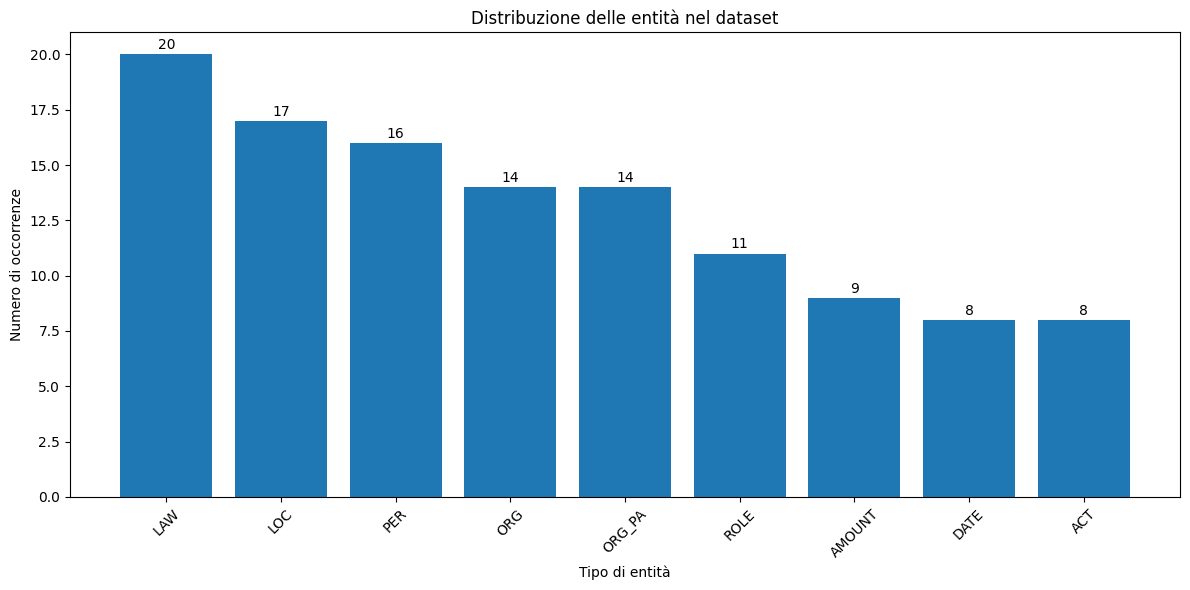

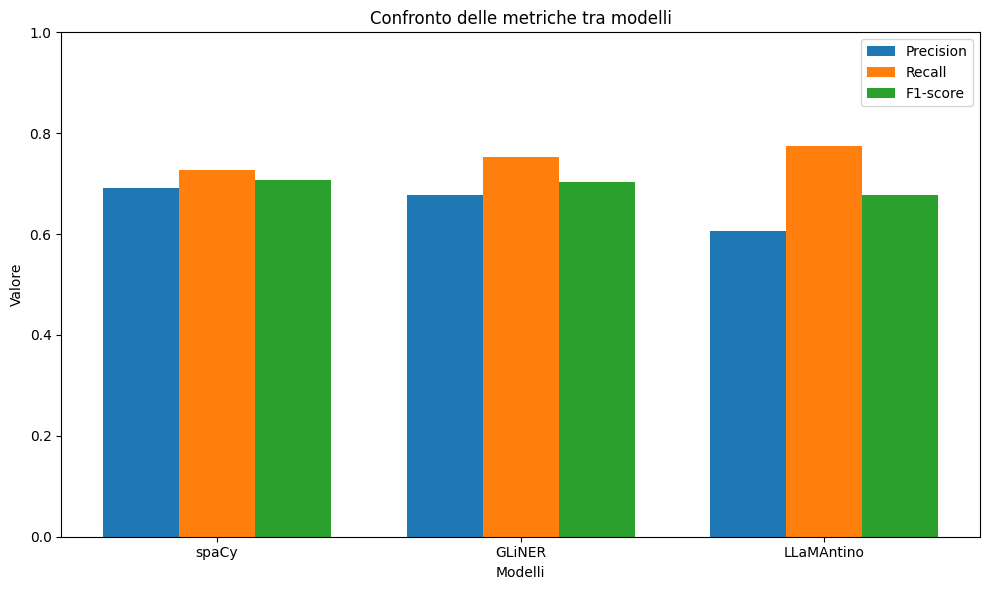

<Figure size 1400x800 with 0 Axes>

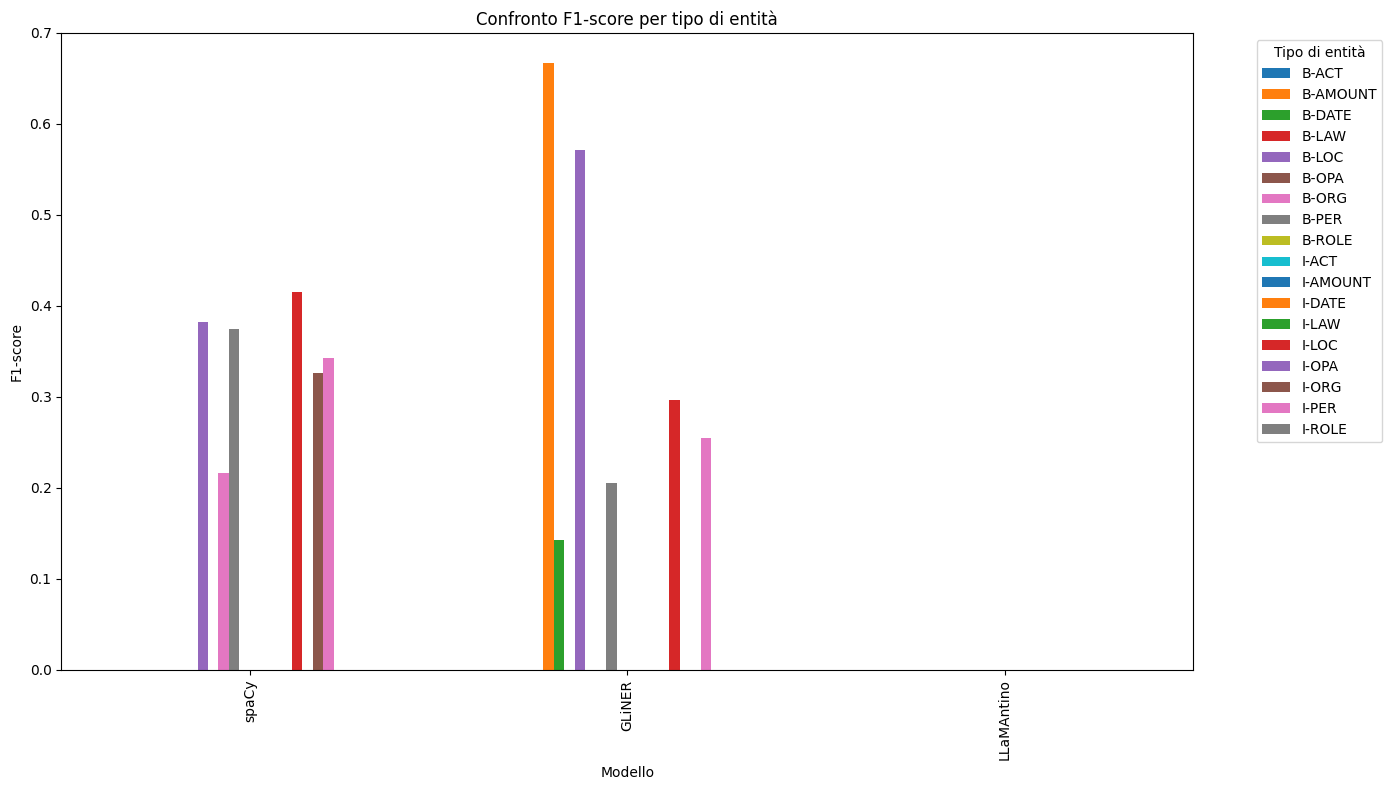

<Figure size 1400x800 with 0 Axes>

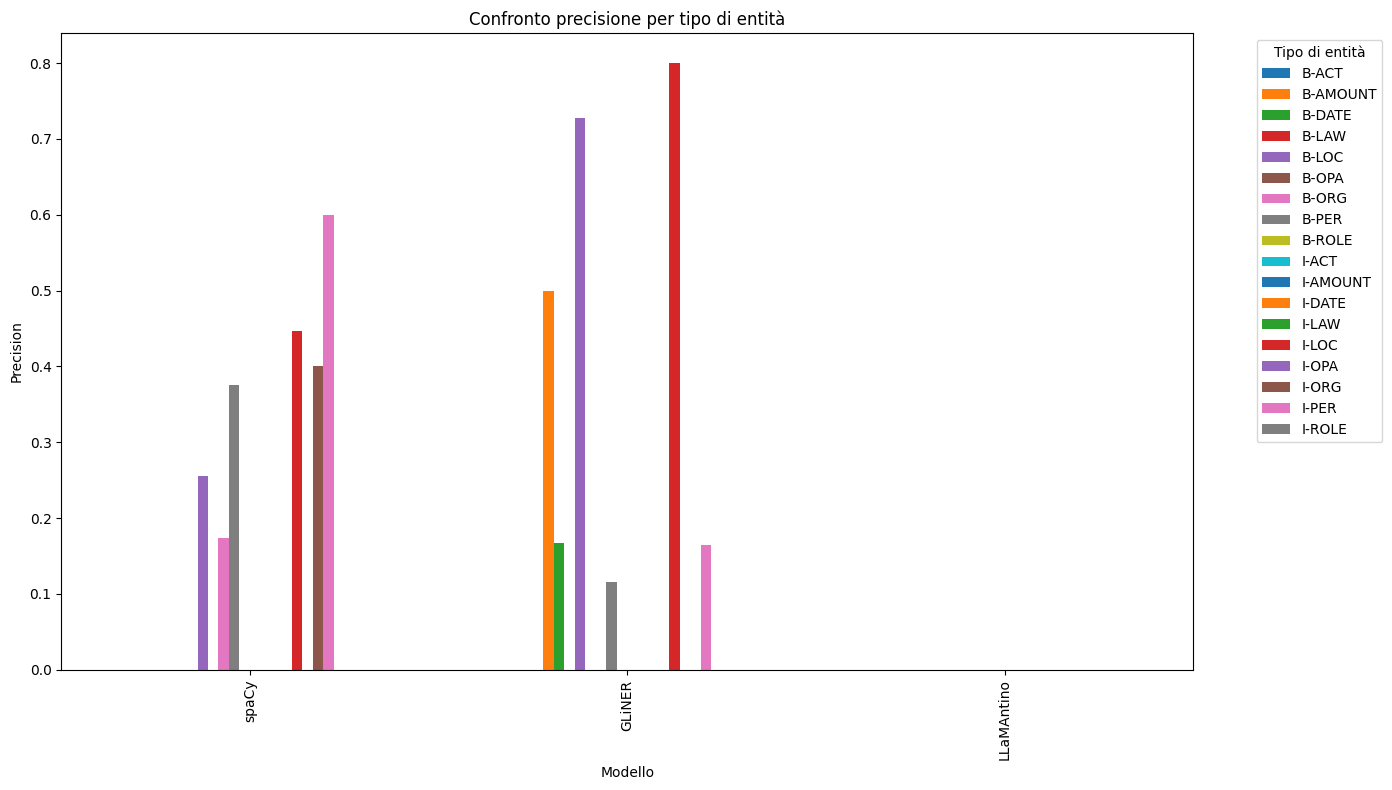

<Figure size 1400x800 with 0 Axes>

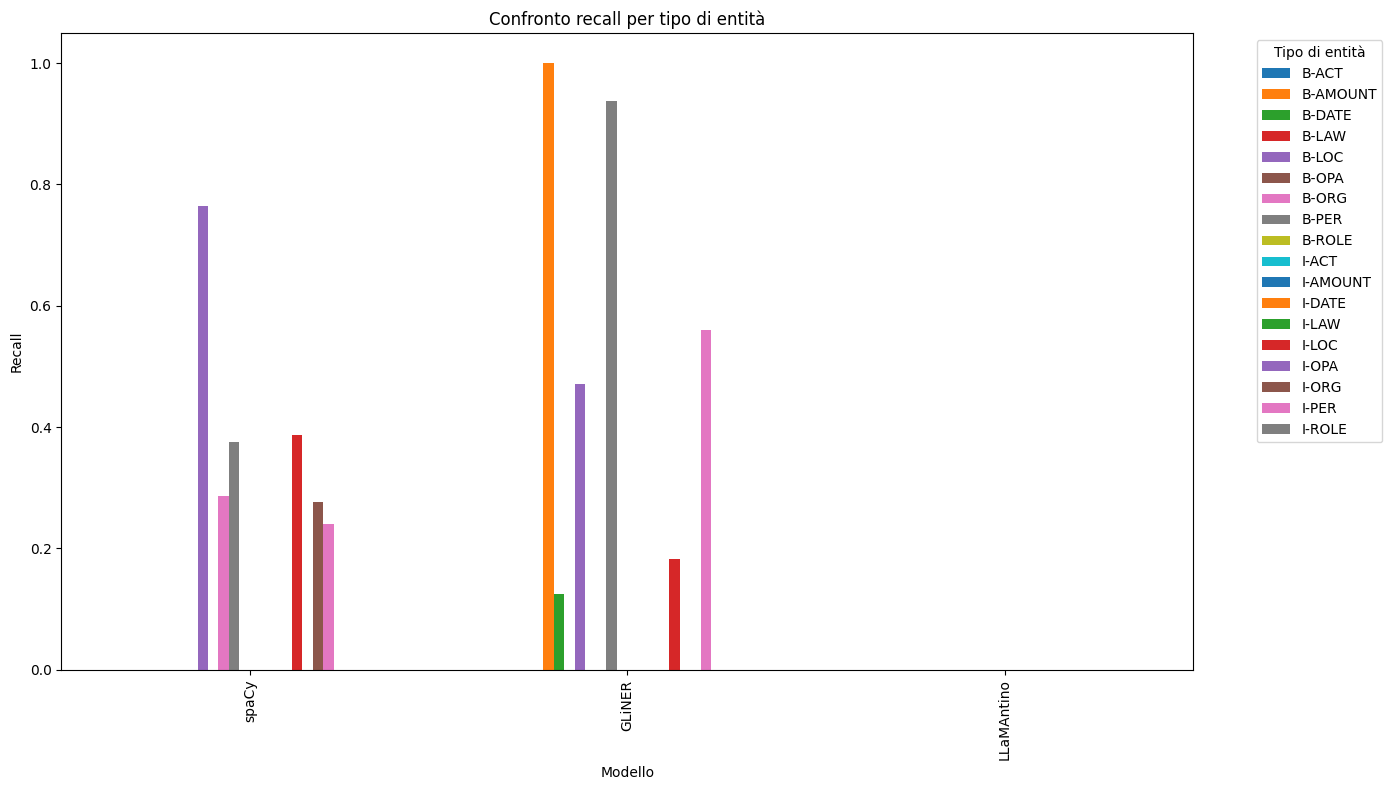


Salvataggio e download dei risultati...
Tutti i risultati sono stati salvati nella cartella 'output_ner_pipeline' e compressi in 'ner_pipeline_results_20250417_143828.zip'
Per scaricare i risultati, utilizza il menu di navigazione file sul lato sinistro di Colab,
trova il file 'ner_pipeline_results_20250417_143828.zip' e fai clic con il tasto destro -> 'Download'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download avviato automaticamente.

Pipeline completata con successo!


<Figure size 1400x800 with 0 Axes>

In [4]:
# Cella per salvare i risultati e scaricarli - versione corretta

import os
import io
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import zipfile

def save_pipeline_results(pipeline, output_dir="output_ner_pipeline"):
    """
    Salva tutti i risultati della pipeline in una cartella e crea un file zip
    per il download

    Args:
        pipeline: L'istanza di NERPipeline con i risultati
        output_dir: Directory di output
    """
    # Crea la directory se non esiste
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 1. Salva i log generali
    with open(f"{output_dir}/execution_log_{timestamp}.txt", "w", encoding="utf-8") as f:
        f.write("=== LOG DI ESECUZIONE PIPELINE NER ===\n")
        f.write(f"Data e ora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        # Informazioni sui modelli
        f.write("Modelli valutati:\n")
        for model_name in pipeline.models.keys():
            f.write(f"- {model_name}\n")

        # Statistiche del dataset
        stats = pipeline.data_loader.get_entity_statistics()
        f.write("\nStatistiche del dataset:\n")
        f.write(f"- Totale token: {stats['total_tokens']}\n")
        f.write(f"- Totale entità: {stats['total_entities']}\n")
        f.write(f"- Densità entità: {stats['entity_density']:.2f}%\n")

        f.write("\nConteggio entità per tipo:\n")
        for entity_type, count in stats["entity_counts"].items():
            f.write(f"- {entity_type}: {count}\n")

    # 2. Salva il report dettagliato delle metriche
    with open(f"{output_dir}/metrics_report_{timestamp}.txt", "w", encoding="utf-8") as f:
        f.write("=== REPORT DETTAGLIATO DI CONFRONTO DEI MODELLI ===\n\n")

        # Tabella di confronto delle metriche aggregate
        metrics_table = {
            "Modello": [],
            "F1 (weighted)": [],
            "Precision": [],
            "Recall": [],
            "Token Accuracy": [],
            "Entity F1": []
        }

        for model_name, metrics in pipeline.model_metrics.items():
            metrics_table["Modello"].append(model_name)
            metrics_table["F1 (weighted)"].append(f"{metrics['weighted_avg']['f1-score']:.4f}")
            metrics_table["Precision"].append(f"{metrics['weighted_avg']['precision']:.4f}")
            metrics_table["Recall"].append(f"{metrics['weighted_avg']['recall']:.4f}")
            metrics_table["Token Accuracy"].append(f"{metrics['token_accuracy']:.4f}")
            metrics_table["Entity F1"].append(f"{metrics['entity_f1']:.4f}")

        # Crea il DataFrame e salva come testo
        metrics_df = pd.DataFrame(metrics_table)
        f.write("Confronto delle metriche aggregate:\n")
        f.write(metrics_df.to_string(index=False))
        f.write("\n\n")

        # Confronto per tipo di entità
        # Estrai tutti i tipi di entità
        all_entities = set()
        for model_name, metrics in pipeline.model_metrics.items():
            all_entities.update(metrics["entity_metrics"].keys())

        all_entities = sorted(all_entities)

        # Crea una tabella per ogni metrica (F1, precision, recall)
        for metric_name in ["f1-score", "precision", "recall"]:
            metric_table = {"Tipo di entità": all_entities}

            for model_name in pipeline.model_metrics.keys():
                metric_table[model_name] = []
                for entity in all_entities:
                    if entity in pipeline.model_metrics[model_name]["entity_metrics"]:
                        value = pipeline.model_metrics[model_name]["entity_metrics"][entity].get(metric_name, 0)
                        metric_table[model_name].append(f"{value:.4f}")
                    else:
                        metric_table[model_name].append("N/A")

            # Crea il DataFrame e salva come testo
            entity_df = pd.DataFrame(metric_table)
            f.write(f"Confronto {metric_name.capitalize()} per tipo di entità:\n")
            f.write(entity_df.to_string(index=False))
            f.write("\n\n")

    # 3. Salva i risultati dettagliati in formato JSON
    detailed_results = {
        "dataset_stats": stats,
        "model_metrics": {}
    }

    for model_name, metrics in pipeline.model_metrics.items():
        detailed_results["model_metrics"][model_name] = metrics

    with open(f"{output_dir}/detailed_results_{timestamp}.json", "w", encoding="utf-8") as f:
        json.dump(detailed_results, f, ensure_ascii=False, indent=2)

    # 4. Salva le metriche in formato CSV (per facile importazione in Excel)
    # Metriche aggregate
    metrics_df.to_csv(f"{output_dir}/aggregate_metrics_{timestamp}.csv", index=False)

    # Metriche per tipo di entità
    for metric_name in ["f1-score", "precision", "recall"]:
        metric_table = {"Tipo di entità": all_entities}

        for model_name in pipeline.model_metrics.keys():
            metric_table[model_name] = []
            for entity in all_entities:
                if entity in pipeline.model_metrics[model_name]["entity_metrics"]:
                    value = pipeline.model_metrics[model_name]["entity_metrics"][entity].get(metric_name, 0)
                    metric_table[model_name].append(value)
                else:
                    metric_table[model_name].append(None)

        entity_df = pd.DataFrame(metric_table)
        entity_df.to_csv(f"{output_dir}/{metric_name}_by_entity_{timestamp}.csv", index=False)

    # 5. Salva i grafici

    # Distribuzione delle entità
    plt.figure(figsize=(12, 6))
    sorted_entities = sorted(stats["entity_counts"].items(), key=lambda x: x[1], reverse=True)
    entities = [e[0] for e in sorted_entities]
    counts = [e[1] for e in sorted_entities]
    bars = plt.bar(entities, counts)
    plt.xlabel('Tipo di entità')
    plt.ylabel('Numero di occorrenze')
    plt.title("Distribuzione delle entità nel dataset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/entity_distribution_{timestamp}.png", dpi=300)
    plt.close()

    # Confronto metriche aggregate
    plt.figure(figsize=(10, 6))
    metrics = ["precision", "recall", "f1-score"]
    models = list(pipeline.model_metrics.keys())
    x = np.arange(len(models))
    width = 0.25

    for i, metric in enumerate(metrics):
        values = [pipeline.model_metrics[model]["weighted_avg"].get(metric, 0) for model in models]
        plt.bar(x + i*width, values, width, label=metric.capitalize())

    plt.xlabel('Modelli')
    plt.ylabel('Valore')
    plt.title("Confronto delle metriche tra modelli")
    plt.xticks(x + width, models)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/metrics_comparison_{timestamp}.png", dpi=300)
    plt.close()

    # Confronto F1-score per tipo di entità
    plt.figure(figsize=(14, 8))
    comparison_data = {entity: [] for entity in all_entities}
    comparison_data["model"] = []

    for model_name, metrics in pipeline.model_metrics.items():
        comparison_data["model"].append(model_name)

        for entity in all_entities:
            if entity in metrics["entity_metrics"]:
                comparison_data[entity].append(
                    metrics["entity_metrics"][entity].get("f1-score", 0)
                )
            else:
                comparison_data[entity].append(0)

    df = pd.DataFrame(comparison_data)
    df = df.set_index("model")
    ax = df.plot(kind='bar', figsize=(14, 8))
    plt.xlabel('Modello')
    plt.ylabel('F1-score')
    plt.title("Confronto F1-score per tipo di entità")
    plt.legend(title='Tipo di entità', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/f1_by_entity_{timestamp}.png", dpi=300)
    plt.close()

    # 6. Salva l'analisi degli esempi
    with open(f"{output_dir}/examples_analysis_{timestamp}.txt", "w", encoding="utf-8") as f:
        f.write("=== ANALISI DEGLI ESEMPI ===\n\n")

        documents = pipeline.data_loader.get_documents()

        # Seleziona alcuni documenti (gli stessi usati in analyze_examples)
        import random
        random.seed(42)  # Per riproducibilità

        num_examples = 3
        if num_examples > len(documents):
            num_examples = len(documents)

        selected_indices = random.sample(range(len(documents)), num_examples)

        for i, idx in enumerate(selected_indices):
            document = documents[idx]
            text = " ".join(document["tokens"])

            f.write(f"\n=== ESEMPIO {i+1} ===\n")
            f.write(f"Testo: {text}\n")

            # Estrai le entità ground truth
            true_entities = pipeline._extract_entities_from_tags(document["tokens"], document["tags"])

            f.write("\nEntità vere:\n")
            for entity in true_entities:
                f.write(f"  {entity['type']}: {entity['text']}\n")

            # Per ogni modello
            for model_name, pred_tags in pipeline.model_predictions.items():
                # Estrai le entità predette
                pred_entities = pipeline._extract_entities_from_tags(document["tokens"], pred_tags[idx])

                f.write(f"\nEntità predette da {model_name}:\n")
                for entity in pred_entities:
                    f.write(f"  {entity['type']}: {entity['text']}\n")

                # Calcola metriche su questo esempio
                true_set = set((e["text"], e["type"]) for e in true_entities)
                pred_set = set((e["text"], e["type"]) for e in pred_entities)

                correct = len(true_set.intersection(pred_set))

                precision = correct / len(pred_set) if pred_set else 0
                recall = correct / len(true_set) if true_set else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

                f.write(f"  Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}\n")

            f.write("\n" + "="*50 + "\n")

    # 7. Crea un file zip con tutti i risultati
    zip_filename = f"ner_pipeline_results_{timestamp}.zip"
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                zipf.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file),
                                          os.path.join(output_dir, '..')))

    # 8. Mostra istruzioni per il download manuale
    print(f"Tutti i risultati sono stati salvati nella cartella '{output_dir}' e compressi in '{zip_filename}'")
    print(f"Per scaricare i risultati, utilizza il menu di navigazione file sul lato sinistro di Colab,")
    print(f"trova il file '{zip_filename}' e fai clic con il tasto destro -> 'Download'.")

    # Alternativa per il download diretto
    try:
        from google.colab import files as colab_files
        colab_files.download(zip_filename)
        print("Download avviato automaticamente.")
    except:
        print("Non è stato possibile avviare il download automatico.")
        print("Utilizza il metodo manuale descritto sopra.")

# Aggiungi alla funzione principale per utilizzare questa funzionalità
def run_ner_pipeline_with_export():
    """
    Versione della funzione principale che include l'esportazione dei risultati
    """
    # Upload dei file gold standard e classi
    from google.colab import files as colab_files

    # Inizializza la pipeline PRIMA di aggiungere modelli
    pipeline = NERPipeline() # crea un'istanza di NERPipeline

    # Modello LLaMAntino (reale con fallback)
    print("Aggiunta del modello LLaMAntino...")
    try:
        # Verifica memoria disponibile
        print("Verifica della memoria disponibile:")
        ram_usage, gpu_usage = check_memory_usage()

        # Carica il modello con quantizzazione 4-bit
        llamantino_model = LLaMAntino3SLIMERModel("expertai/LLaMAntino-3-SLIMER-IT")
        pipeline.add_model("LLaMAntino (reale)", llamantino_model)

        verify_llamantino_model(llamantino_model)

        if hasattr(llamantino_model, 'is_real_model') and llamantino_model.is_real_model:
            print("✅ Confermato: la pipeline sta utilizzando il modello LLaMAntino REALE")
        else:
            print("⚠️ Attenzione: la pipeline sta utilizzando il modello LLaMAntino SIMULATO")

    except Exception as e:
        print(f"Errore nell'inizializzazione di LLaMAntino: {e}")
        print("Utilizzo della versione simulata come fallback...")
        llamantino_model = LLaMAntino3SLIMERModel_Simulated()
        pipeline.add_model("LLaMAntino (simulato)", llamantino_model)

    print("Caricamento dei file gold standard e classi...")
    print("Per favore, carica il file gold_standard_30.iob")
    uploaded_gold = colab_files.upload()

    print("\nPer favore, carica il file classes.txt")
    uploaded_classes = colab_files.upload()

    # Ottieni i nomi dei file caricati
    gold_file = list(uploaded_gold.keys())[0]
    classes_file = list(uploaded_classes.keys())[0]

    print(f"\nFile caricati: {gold_file}, {classes_file}")

    # Inizializza la pipeline
    print("\nInizializzazione pipeline...")
    pipeline = NERPipeline(gold_file, classes_file)

    # Carica i dati
    pipeline.load_data()

    # Aggiungi i modelli
    print("\nAggiunta dei modelli...")

    # Modello spaCy
    print("Aggiunta del modello spaCy...")
    spacy_model = SpacyNERModel("it_core_news_lg")
    pipeline.add_model("spaCy", spacy_model)

    # Modello GLiNER (simulato)
    print("Aggiunta del modello GLiNER (simulato)...")
    gliner_model = GLiNERModel()
    pipeline.add_model("GLiNER", gliner_model)

    # Modello LLaMAntino (simulato)
    print("Aggiunta del modello LLaMAntino (simulato)...")
    llamantino_model = LLaMAntino3SLIMERModel()
    pipeline.add_model("LLaMAntino", llamantino_model)

    # Valuta tutti i modelli
    print("\nValutazione dei modelli in corso...")
    pipeline.evaluate_all_models()

    # Stampa report dettagliato
    print("\nStampa report dettagliato...")
    pipeline.print_detailed_report()

    # Analizza alcuni esempi
    print("\nAnalisi di esempi...")
    pipeline.analyze_examples(3)

    # Visualizza i risultati
    print("\nVisualizzazione dei risultati...")
    pipeline.visualize_results()

    # Salva e scarica i risultati
    print("\nSalvataggio e download dei risultati...")
    save_pipeline_results(pipeline)

    print("\nPipeline completata con successo!")

# Esegui la pipeline con esportazione
if __name__ == "__main__":
    run_ner_pipeline_with_export()